In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [32]:
# Import functions directly from github
# Important: note that we use raw.githubusercontent.com, not github.com

import requests
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/plot_utility.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('plot_utility.py', 'w') as f:
    f.write(r.text)

# import the function we want from that file
from plot_utility import plot_tme

# Constants

In [50]:
# System Parameters
m = 0.5 # mass
l = 0.2 # distance from rotor to COM
I = 2/5*m*l**2 # Moment of inertia (Iyy) -- assuming drone is a sphere (it is not)
g = 9.81 # gravity constant

# Control Parameters
tau_k_theta = 10 # torque control to stabilize theta
tau_k_thetadot = 20 # torque control to provide thetadot damping
tau_k_x = 0.01 # torque control to control x position
tau_k_xdot = 0.2 # torque control to provide xdot damping
F_k_z = 1000 # Force control to control z position
F_k_zdot = 10000 # Force control to control z position

F0 = m*g

# Noise for measurements:
v = [0.01, 0.001, 0.2, 0.2, 0.003, 0.003]

# Desired trajectory

In [34]:
def desired_trajectory(t):
    theta_des = 0*np.ones_like(t)
    z_des = 1*np.ones_like(t)
    x_des = np.sin(0.01*t)
    return theta_des, x_des, z_des

# Nonlinear continuous time dynamics with control

In [35]:
def control(X, t):
    theta, thetadot, x, xdot, z, zdot = X

    # desired trajectory
    theta_des, x_des, z_des = desired_trajectory(t)

    # error
    x_err = x_des - x
    z_err = z_des - z

    # control
    tau = -(tau_k_x*x_err - tau_k_xdot*xdot)  + (tau_k_theta*(-theta) - tau_k_thetadot*thetadot)
    F = (F_k_z*z_err - F_k_zdot*zdot)

    return F, tau

In [36]:
def f(X, t):
    theta, thetadot, x, xdot, z, zdot = X

    # control
    F, tau = control(X, t)

    # dynamics
    d_theta = thetadot
    d_thetadot = tau/I
    d_x = xdot
    d_xdot = -F*np.sin(theta)/m
    d_z = zdot
    d_zdot = (F*np.cos(theta)-m*g)/m

    d_x = [d_theta, d_thetadot, d_x, d_xdot, d_z, d_zdot]

    return d_x

# Run simulation

In [37]:
t = np.arange(0, 1000, 0.1)

In [38]:
x0 = [(np.random.random()-0.5)*1e-3 for i in range(6)]

In [39]:
result = odeint(f, x0, t)
X = result.T

# Plot results

In [40]:
theta = X[0, :]
x = X[2, :]
z = X[4, :]

theta_des, x_des, z_des = desired_trajectory(t)

<Axes: xlabel='Time', ylabel='z'>

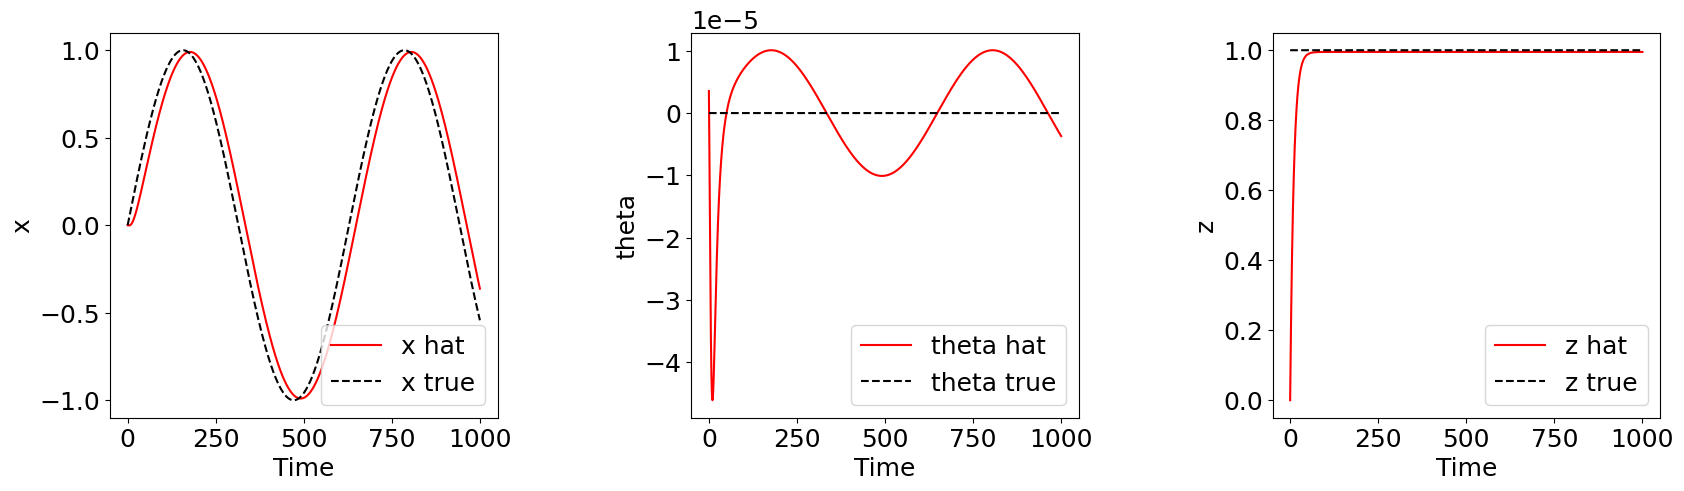

In [41]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t, x_des, None, x, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(t, theta_des, None, theta, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(t, z_des, None, z, label_var='z', ax=ax3)

# Measurements

In [51]:
def h(X, v, t):
    theta, thetadot, x, xdot, z, zdot = X

    F, tau = control(X, t)

    xddot = -F*np.sin(theta)/m
    zddot = (F*np.cos(theta)-m*g)/m

    y = np.array([theta, thetadot, x, z, xddot, zddot])
    noise = np.array( [np.random.normal(0, vi) for vi in v] )

    return (y + noise).tolist()

In [52]:
Y = np.vstack( [h(X[:,i], v, t[i]) for i in range(X.shape[1]) ] ).T
# y0 = [(np.random.random()-0.5)*1e-3 for i in range(6)]
# result = odeint(h, y0, t)
# Y = result.T

<Axes: xlabel='Time', ylabel='z'>

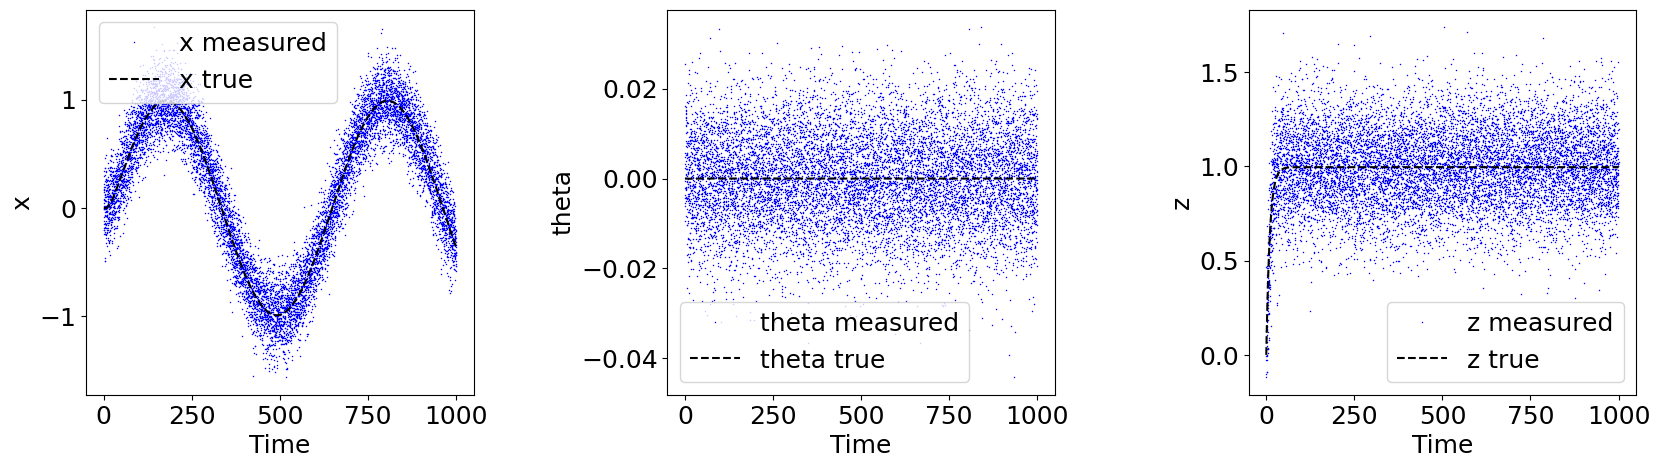

In [53]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t, x, Y[2,:], None, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(t, theta, Y[0,:], None, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(t, z, Y[3,:], None, label_var='z', ax=ax3)

<Axes: xlabel='Time', ylabel='zddot'>

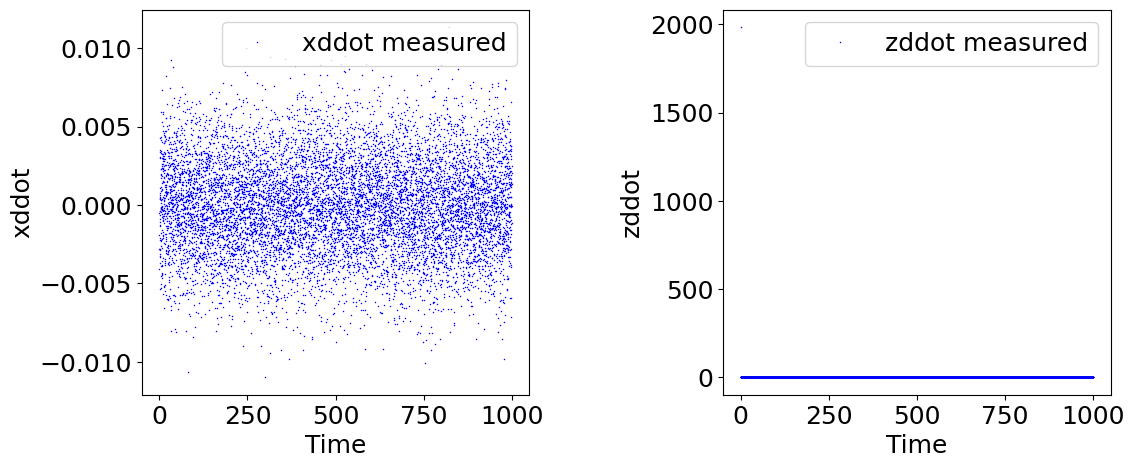

In [56]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t,None,Y[4,:], None, label_var='xddot', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(t,None,Y[5,:], None, label_var='zddot', ax=ax2)

# Exercise

Modify the dynamics, simulation, and measurement such that acceleration can be coded as a measurement.